In [1]:
# importing general libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs # for generating dataset
import queue

Generating **random dataset** with **2 Features**

In [2]:
X, y = make_blobs(n_samples = 950, centers = 3, n_features = 2, random_state=42, cluster_std = 1)
print("X shape: ", X.shape)

X shape:  (950, 2)


In [3]:
# adding some noise points to the dataset
total_noise_points = 50
noise_X = np.random.uniform(low = X[:,0].min(), high = X[:,1].max(),
                            size = (total_noise_points, 2))
X_combined = np.vstack((X, noise_X))

In [4]:
features = [f"feature_{i+1}" for i in range (X.shape[1])]
# Transforming the nd_array X to a dataframe
data = pd.DataFrame(X_combined, columns = features)
data

,feature_1,feature_2
0,-3.101592,8.150295
1,6.022038,2.621880
2,5.252653,0.919754
3,-4.980842,8.217391
4,4.193695,0.083629
...,...,...
995,-8.868213,-4.867584
996,-1.750122,6.084018
997,-8.003442,3.781821
998,9.484139,1.566504


In [5]:
data.describe()

,feature_1,feature_2
count,1000.000000,1000.000000
mean,-1.418645,1.416721
std,4.984480,6.548915
min,-9.582859,-9.801460
25%,-6.146399,-6.062851
50%,-2.432611,2.094190
75%,4.096250,8.250341
max,12.683916,12.867018


**Visualizing** the dataset

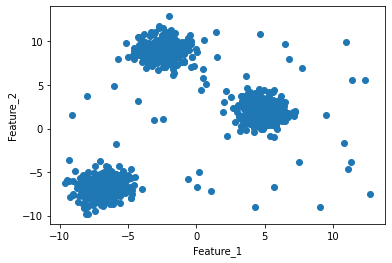

In [6]:
# using scatterplot
plt.scatter(x = data['feature_1'], y = data['feature_2'])
plt.xlabel("Feature_1")
plt.ylabel("Feature_2")
plt.show()

**Algorithm for DBSCAN**  
*Step 1*: Initialize the algorithm by selecting an arbitrary point that has not been visited.  
*Step 2*: Retrieve all points in the ε-neighborhood of this point and mark it as visited.  
*Step 3*: If this point has a sufficient number of points in its ε-neighborhood, create a cluster starting with this point.  
*Step 4*: Expand the cluster by adding all reachable points to the cluster.  
*Step 5*: Repeat the process for all unvisited points until all points have been visited.  
*Step 6*: The algorithm terminates when all points have been visited and clustered.  

In [7]:
temp_data = data.copy()

In [8]:
def euclidean_distance(pt1, pt2):
    distance = 0
    for i in range(len(pt1)):
        distance += (pt1[i] - pt2[i])**2
    return distance**0.5

def nextId(cluster_Id):
    return cluster_Id + 1

def get_neighbors(data, point, eps):    # returns index of neighbors of a given point 
    neighbors_index = []
    
    for i in range(len(data)):
        if euclidean_distance(data.iloc[i].values, point) <= eps:
            neighbors_index.append(i)
    return neighbors_index

def assign_cluster_id(temp_data, seeds_index, cluster_Id):   # assigns clusterId to data points
    for i in seeds_index:
        temp_data['clusterId'][i] = cluster_Id

# expand the cluster around a given point
def expand_cluster(temp_data, data, index, point, eps, min_pts, cluster_Id):
    seeds_index = get_neighbors(data, point, eps) # we get a list of indexes of neighbors of the 'point'
    if len(seeds_index) < min_pts:
        temp_data['clusterId'][index] = -1  # we assign the point as noise
        return False
    else:
        assign_cluster_id(temp_data, seeds_index, cluster_Id)  # see the function implemention above
        seeds_index.remove(index)
        while len(seeds_index) > 0:
            current_point_index = seeds_index[0]
            sub_seed_index = get_neighbors(data, data.iloc[current_point_index].values, eps)
            if len(sub_seed_index) >= min_pts:
                for sub_idx in sub_seed_index:
                    if temp_data['clusterId'][sub_idx] == None: # if point is unclassified
                        seeds_index.append(sub_idx) # then append it to seed_index
                    temp_data['clusterId'][sub_idx] = cluster_Id
            seeds_index.remove(current_point_index)
        return True

def DBSCAN(data, temp_data, eps, min_pts):
    cluster_Id = 0
    temp_data['clusterId'] = np.array([None]* len(data))
    for i in range(len(data)):
        if temp_data['clusterId'][i] == None:
            if expand_cluster(temp_data, data, i, data.iloc[i], eps, min_pts, cluster_Id):
                cluster_Id = nextId(cluster_Id)

In [9]:
DBSCAN(data, temp_data, 1.5, 10)

<ipython-input-8-79d63777cbc5>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_data['clusterId'][i] = cluster_Id
<ipython-input-8-79d63777cbc5>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_data['clusterId'][sub_idx] = cluster_Id
<ipython-input-8-79d63777cbc5>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_data['clusterId'][index] = -1  # we assign the point as noise


In [11]:
temp_data

,feature_1,feature_2,clusterId
0,-3.101592,8.150295,0
1,6.022038,2.621880,1
2,5.252653,0.919754,1
3,-4.980842,8.217391,0
4,4.193695,0.083629,1
...,...,...,...
995,-8.868213,-4.867584,2
996,-1.750122,6.084018,0
997,-8.003442,3.781821,-1
998,9.484139,1.566504,-1


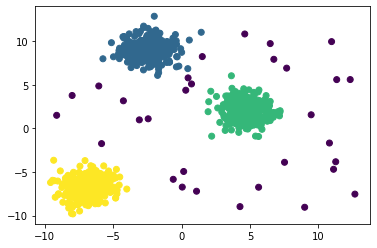

In [12]:
plt.scatter(x=data['feature_1'], y = data['feature_2'], c = temp_data['clusterId'])